<a href="https://colab.research.google.com/github/mukul-mschauhan/GenerativeAI/blob/main/Kaggle%20Disaster%20Tweet%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Competition Description
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

https://www.kaggle.com/competitions/nlp-getting-started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [33]:
# Import train and test set

train = pd.read_csv("/content/disaster_train.csv")
test = pd.read_csv("/content/disaster_test.csv")

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [34]:
# Lets combine the train and test
combined = pd.concat([train, test], ignore_index = False)

In [35]:
# Lets check the Shape of the Dataset
train.shape, test.shape, combined.shape

((7613, 5), (3263, 4), (10876, 5))

### Exploratory Data Analysis & Feature Extraction

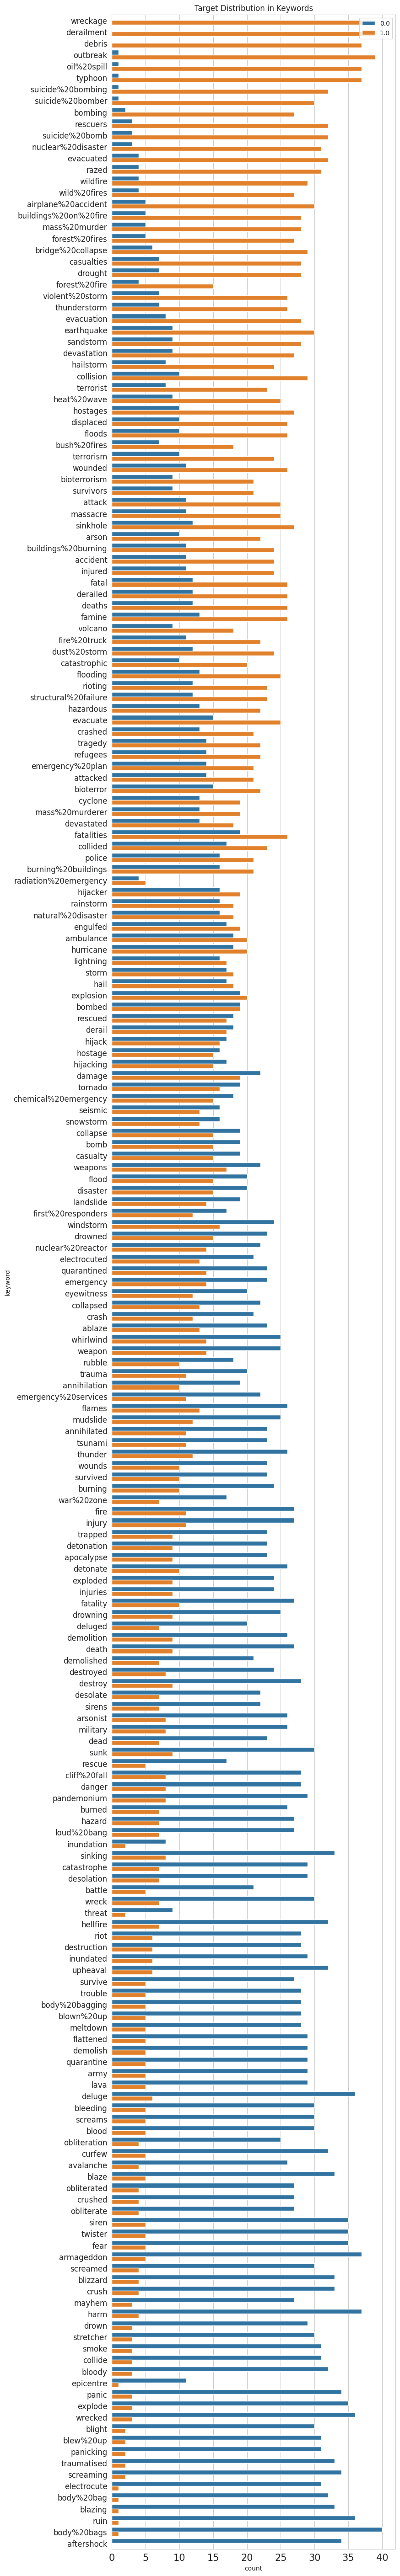

In [36]:
# Keyword Analysis
combined['target_mean'] = combined.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

# Reset the index of combined DataFrame before plotting to avoid duplicate index issues
combined = combined.reset_index()

sns.countplot(y=combined.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=combined.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

combined.drop(columns=['target_mean'], inplace=True)

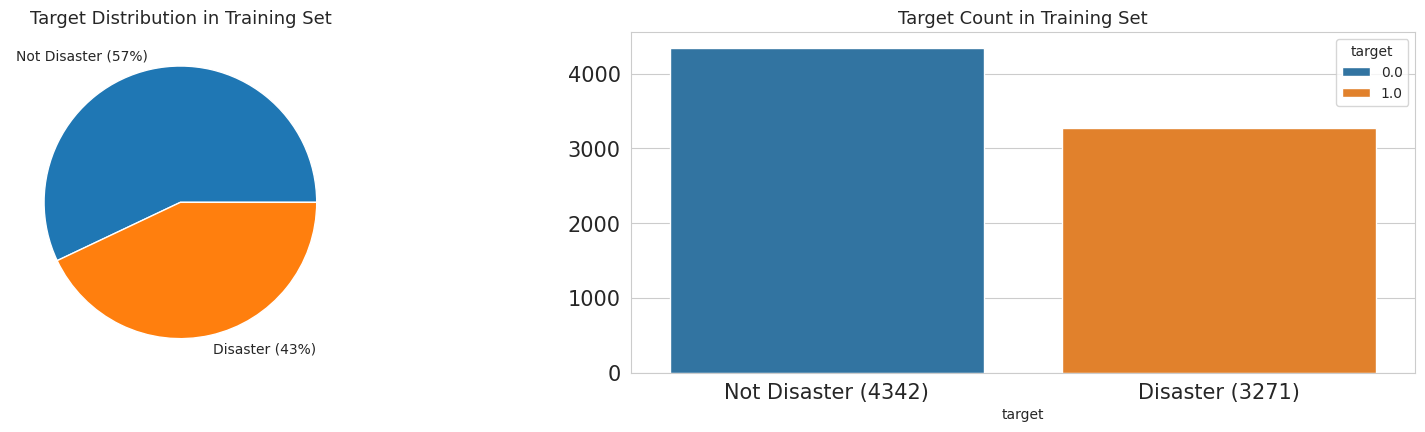

In [37]:
# Check for Target Variable

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

combined.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=combined['target'], hue=combined['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

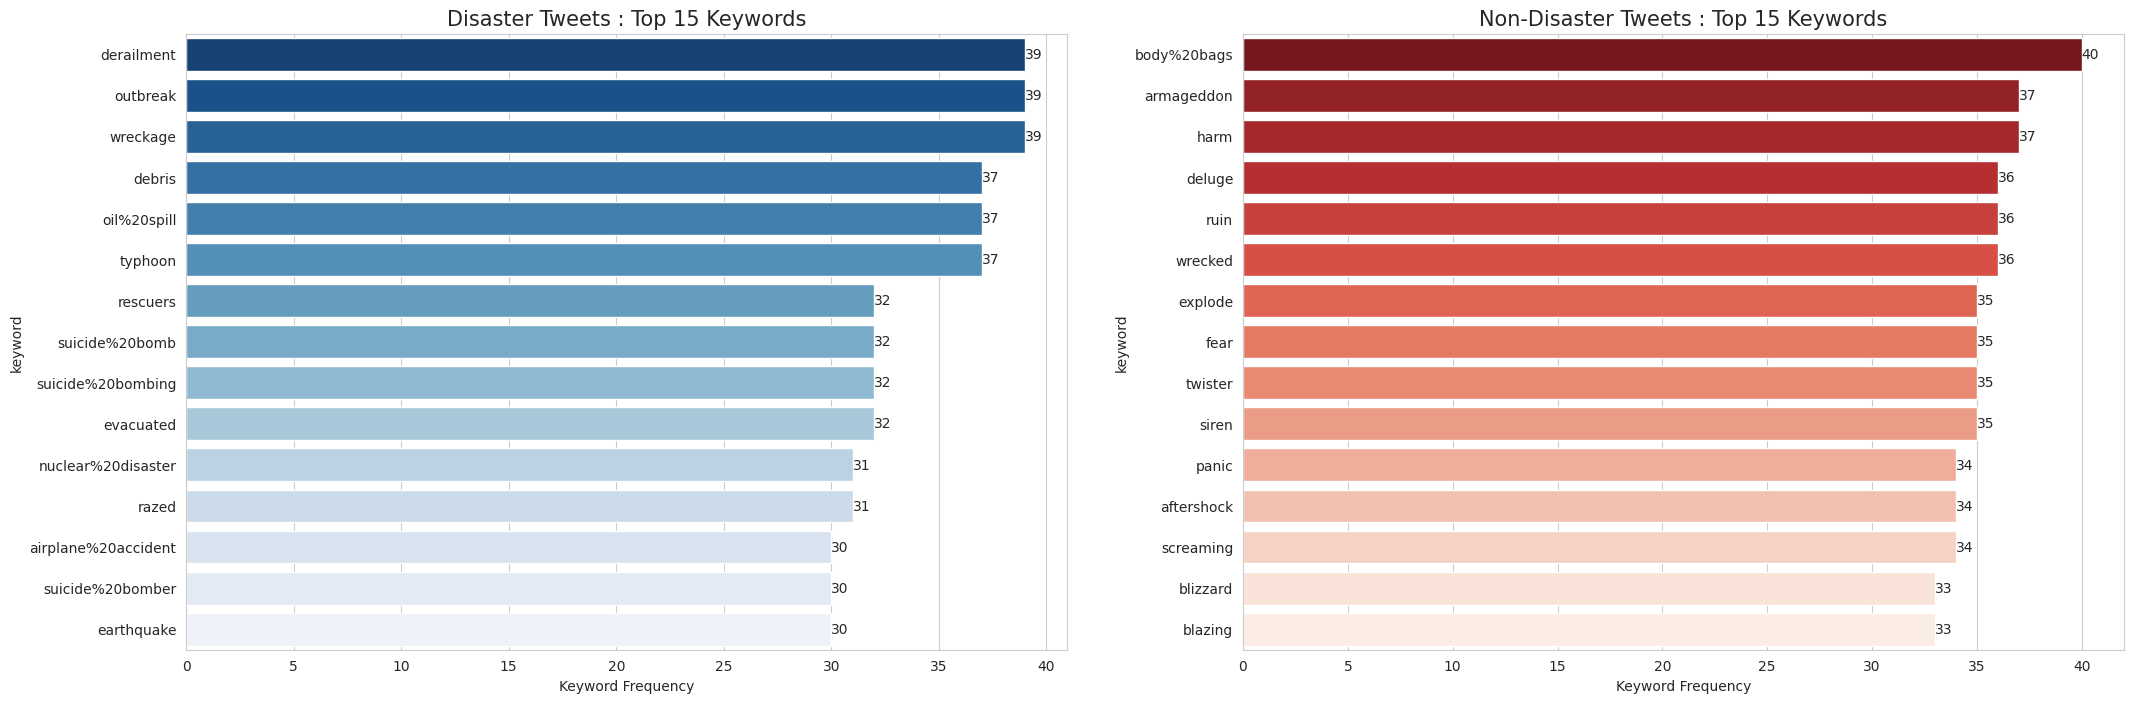

In [38]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
non_disaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(25,8))
ax1 = sns.barplot(y=disaster_keywords[0:15].index, x=disaster_keywords[0:15], orient='h', ax=ax[0], palette="Blues_r")
for container in ax1.containers:
    ax1.bar_label(container)
ax[0].set_title("Disaster Tweets : Top 15 Keywords",fontsize=15)
ax[0].set_xlabel("Keyword Frequency")

ax2 = sns.barplot(y=non_disaster_keywords[0:15].index, x= non_disaster_keywords[0:15], orient='h', ax=ax[1], palette="Reds_r")
for container in ax2.containers:
    ax2.bar_label(container)
ax[1].set_title("Non-Disaster Tweets : Top 15 Keywords",fontsize=15)
ax[1].set_xlabel("Keyword Frequency")
plt.show()

In [40]:
combined['length']  = combined["text"].apply(len)

In [41]:
print('Tweet chraracter length for:',combined['text'][0],'is',combined['length'][0])

Tweet chraracter length for: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all is 69


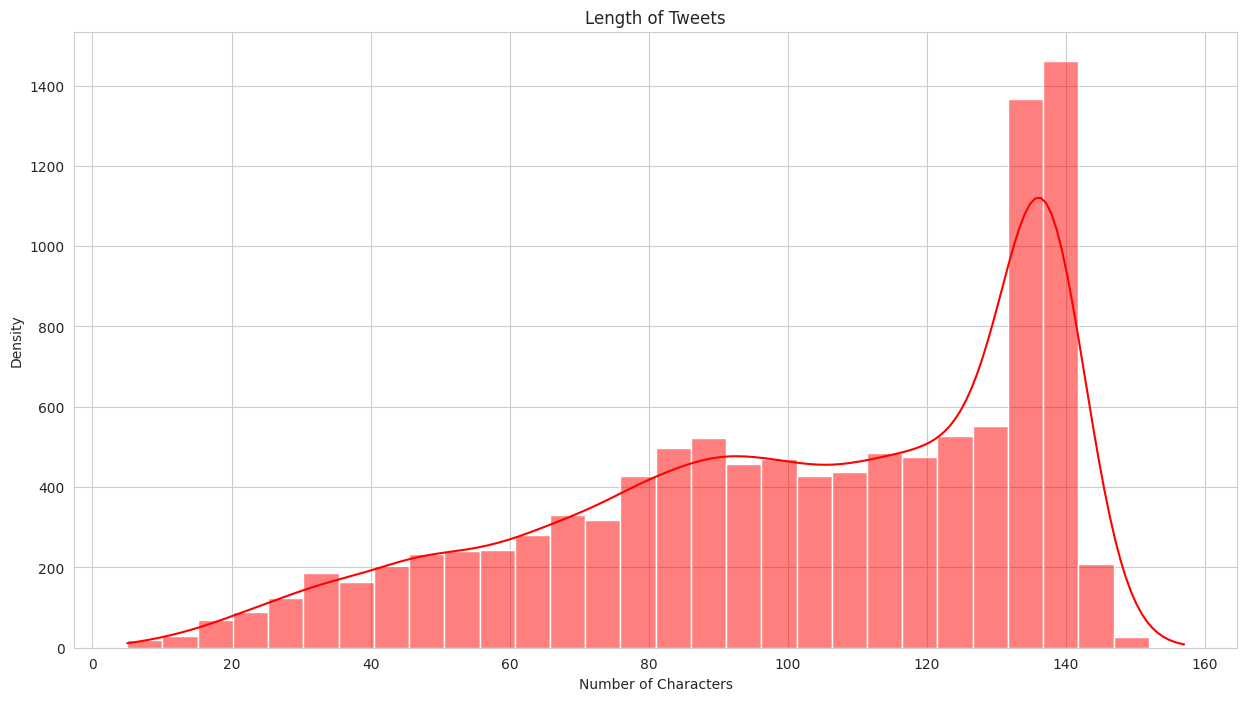

In [42]:
plt.figure(figsize=(15,8))

sns.histplot(combined['length'], kde=True,color='red',bins=30)
plt.title("Length of Tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

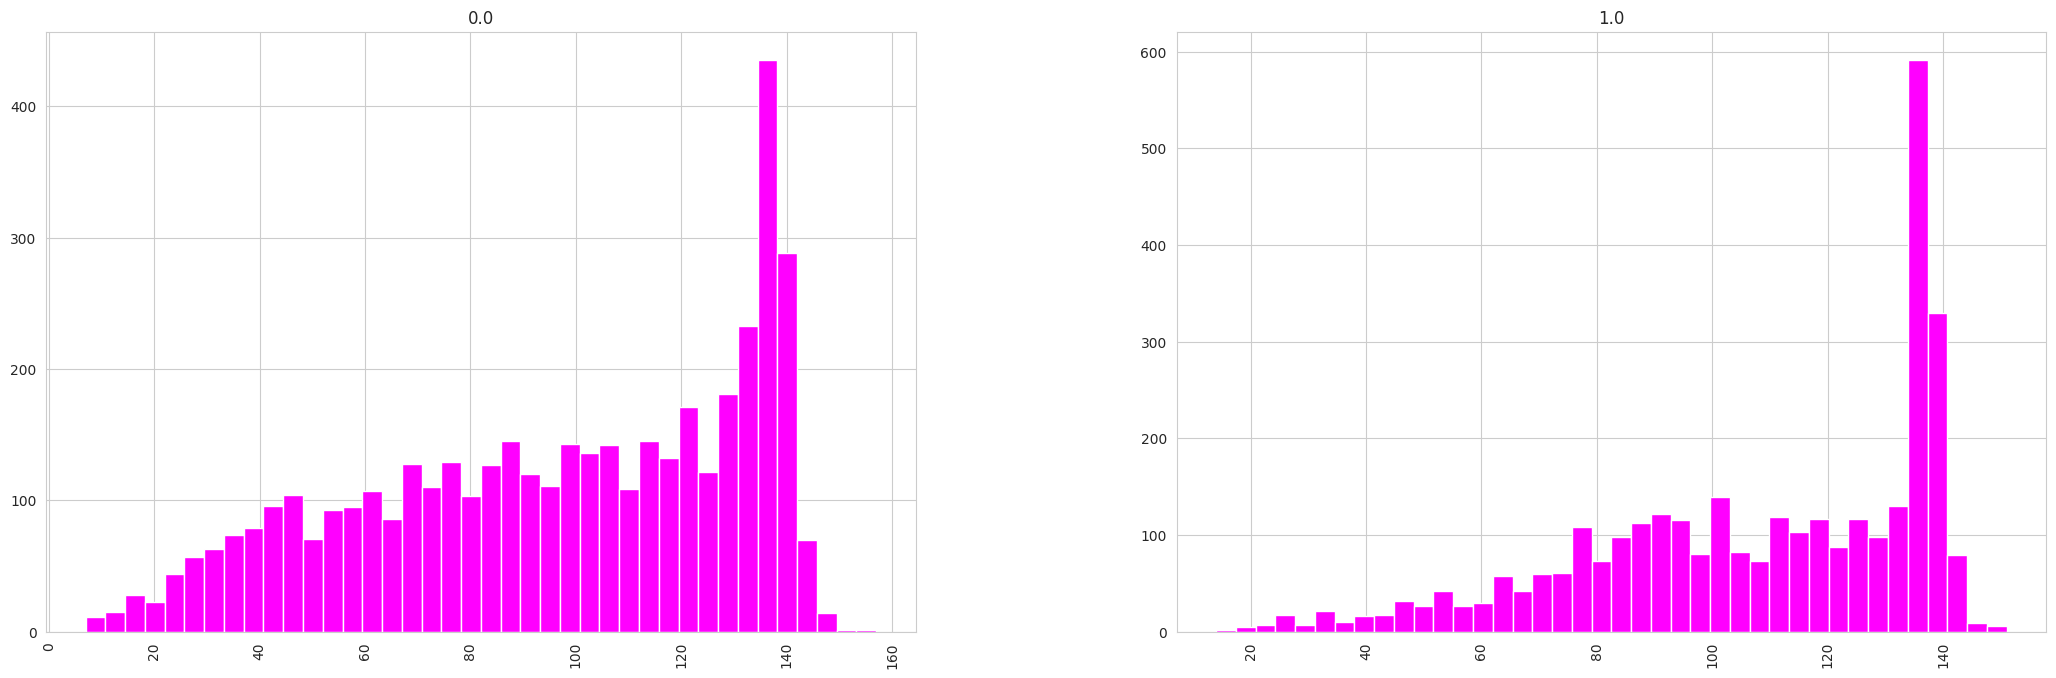

In [43]:
combined.hist(column='length',
           by = 'target', bins =40, figsize= (25,8), color ="magenta")
plt.show()

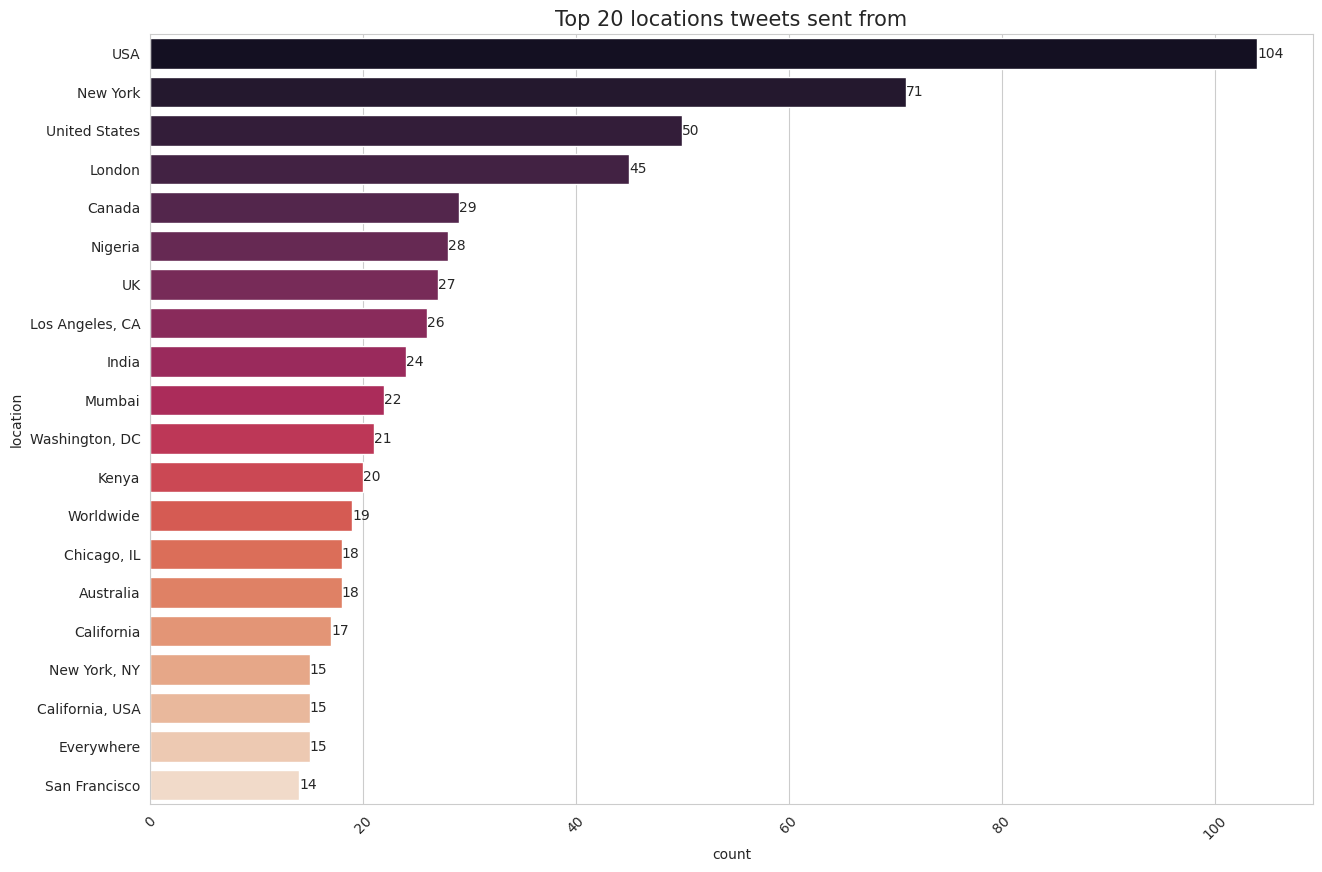

In [44]:
# Top 20 Tweets

sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(15,10))

locations = train["location"].value_counts()

# Create a DataFrame for plotting with the top 20 locations and their counts
top_locations = locations[0:20].reset_index()  # Reset index to create a column for location names
top_locations.columns = ['location', 'count']  # Rename columns for clarity

ax = sns.barplot(y="location", x="count", data=top_locations, palette='rocket') # Use top_locations DataFrame
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 20 locations tweets sent from',fontsize=15)
plt.xticks(rotation=45)
plt.show()

## Data Cleaning

In [45]:
import re # Regular Expressions
import nltk # NLP Library ~ Spacy

# Download the Stopwords
nltk.download("stopwords")

from nltk.corpus import stopwords

stop_words = stopwords.words("english") # List of the Stopwords
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
# Function to remove the stopwords
def remove_stops(text):
  # Step1: Convert the text into lowercase
  text = text.lower()
  # Step2: Tokenize the Text
  words = text.split()
  # Step3: Removal of stopwords
  newwords = [word for word in words if word not in stop_words]
  return(" ".join(newwords))

combined["Cleansed"] = combined.text.apply(remove_stops)

In [57]:
# Function to Preview the Noise in the Data...
def noisy(text):
  text = re.findall("@\w+|[^a-zA-Z0-9\s]+", text)
  return(text)

combined["noise"]= combined.Cleansed.apply(noisy)
noise_in_data = set(char for sublist in combined.noise for char in sublist)

print(sorted(noise_in_data))

['!', '!!', '!!!', '!!!!', '!!!!!', '!!!!!!', '!!!!!!!!!', '!!!!!!!!!!', '!!!!!!!!!!!!', '!!!!!!!!!!!#', "!!!!'", '!!!!.', '!!!!:', '!!!...', '!!!?', '!!!??', '!!!????', "!!'", '!!:', "!!?!?!?!'", "!!?!??!?'", '!!??', '!!????', '!#', '!&', "!'", '!(', '!)', '!*', '!-', '!--', '!...', '!:', '!?', '!?!', "!?'", '!??', '!????', '!]', '!\x89û_', '!\x89û\x9d', '#', '##', '#?', '#??', '#???', '#????', '#???????', '#??????????', '#???????????', '#????_?????', '#??_????_?????', '#\x89û_', '$', '$$', '$$$$', '$&', '%', '%)', '%.', '%;', '&', "'", "'!", "'#", "'&", "''", "'''", "'':", "')", "').", "'-", "'.", "'.#", "'..", "'...", "'......", "':", "';", "'?", "'?!", "'??", "'@", "'[+", "'\x89û\x9d", "'\x89ûó", '(', '(#', '($', '($)', '(&', "('", '((', '(+', '(-', '(.', '(:', '(?', '(?)', '(@', '([', '(\x89û_', '(\x89û÷', '(å£', ')', ')!', ")'", '))', ')):', ').', ')...', ')....', ')/', '):', ')]', ')\x89û_', '*', '*!!!!!!', '**', '***', '***-', '*.', '+', '+)', '++', '+++++', '++++++', '+.', '+:

In [58]:
# Function to clean the Noise...
def clean_noise(text):
  text = re.sub('@\w+|[^a-zA-Z0-9\s]+', "", text)
  return(text.strip())

combined["Cleansed_New"] = combined.Cleansed.apply(clean_noise)

In [59]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize # Convert the Sentences into Tokens

all_tokens = [tokens for word in combined.Cleansed_New for tokens in word_tokenize(word)]

In [61]:
freqdist = pd.DataFrame(FreqDist(all_tokens).items(), columns = ["Tokens", "Freq"]).\
sort_values(by = "Freq", ascending = False)

freqdist.head()

,Tokens,Freq
132,like,490
345,amp,434
8,fire,359
240,get,336
164,new,328


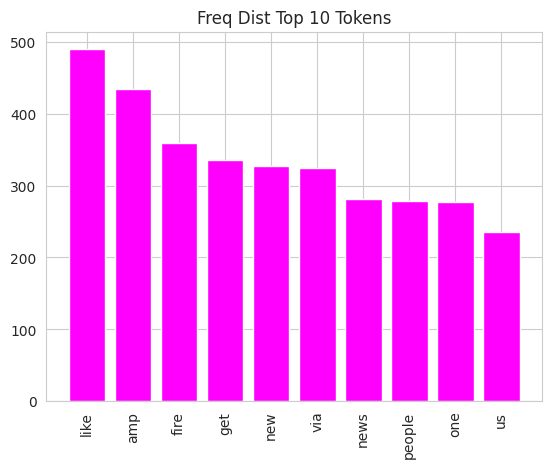

In [63]:
# Freq Distt Plot...
plt.bar(freqdist["Tokens"][0:10],
        freqdist["Freq"][0:10], color = "magenta")
plt.title("Freq Dist Top 10 Tokens")
plt.xticks(rotation = 90)
plt.show()

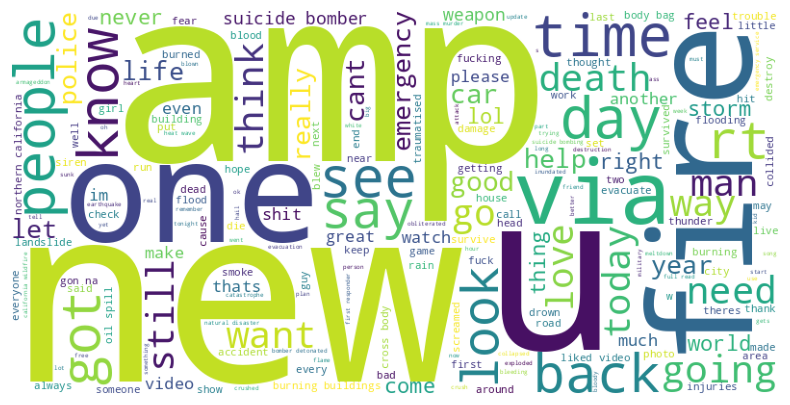

In [64]:
#!pip install wordcloud

from wordcloud import WordCloud

cloud = WordCloud(width = 800,
                  height = 400,
                  background_color = "white").generate(" ".join(all_tokens))

plt.figure(figsize = (10, 5))
plt.imshow(cloud)
plt.axis("off")
plt.show("Word Cloud")

In [65]:
combined.head()

,index,id,keyword,location,text,target,length,Cleansed,noise,Cleansed_New
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,69,deeds reason #earthquake may allah forgive us,[#],deeds reason earthquake may allah forgive us
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,38,forest fire near la ronge sask. canada,[.],forest fire near la ronge sask canada
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,133,residents asked 'shelter place' notified offic...,"[', ', .]",residents asked shelter place notified officer...
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65,"13,000 people receive #wildfires evacuation or...","[,, #]",13000 people receive wildfires evacuation orde...
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,88,got sent photo ruby #alaska smoke #wildfires p...,"[#, #]",got sent photo ruby alaska smoke wildfires pou...


In [67]:
newdf = combined.drop(['index', 'id', 'keyword', 'location', 'text','length',
       'Cleansed', 'noise'], axis =1)

newdf.head()

,target,Cleansed_New
0,1.0,deeds reason earthquake may allah forgive us
1,1.0,forest fire near la ronge sask canada
2,1.0,residents asked shelter place notified officer...
3,1.0,13000 people receive wildfires evacuation orde...
4,1.0,got sent photo ruby alaska smoke wildfires pou...


In [68]:
# Resplit it back in train and test
newtrain = newdf.loc[0:train.shape[0]-1]
newtest = newdf.loc[train.shape[0]:]

train.shape, test.shape, newtrain.shape, newtest.shape

((7613, 5), (3263, 4), (7613, 2), (3263, 2))

In [69]:
newtest.head()

,target,Cleansed_New
7613,NaN,happened terrible car crash
7614,NaN,heard earthquake different cities stay safe ev...
7615,NaN,forest fire spot pond geese fleeing across str...
7616,NaN,apocalypse lighting spokane wildfires
7617,NaN,typhoon soudelor kills 28 china taiwan


In [70]:
#  Delete the Target from test Set
newtest.drop("target", axis = 1, inplace = True)

In [73]:
newtrain["target"] = newtrain.target.astype(int)

In [80]:
# Split the Data in X and y
X = newtrain.drop("target", axis = 1)
y = newtrain.target

In [81]:
# BOW Model...

from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform the train
X_train = vectorizer.fit_transform(X["Cleansed_New"]).toarray()

# Transform Test Set
x_test = vectorizer.transform(newtest["Cleansed_New"])

# Modeling
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
pred = lg.fit(X_train, y).predict(x_test) # Prediction

In [83]:
# Sample Submission

submission = pd.DataFrame({"id":test.id, "target":pred})
submission.to_csv("LGREG.csv", index = False)

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object
tf_vectorizer = TfidfVectorizer()

# Fit and transform the train
X_train = tf_vectorizer.fit_transform(X["Cleansed_New"]).toarray()

# Transform Test Set
x_test = tf_vectorizer.transform(newtest["Cleansed_New"])

# Modeling
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
pred = lg.fit(X_train, y).predict(x_test) # Prediction

In [85]:
submission = pd.DataFrame({"id":test.id, "target":pred})
submission.to_csv("TF-LGREG.csv", index = False)

In [ ]:
# Try Random Forest Model...